# X-Inactivation Analysis

Detection of X-inactivation via differential variance

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import scanpy.api as sc
import scipy as sp
import itertools
import numpy as np
import scipy.stats as stats
from scipy.integrate import dblquad
import scipy.sparse as sparse
import seaborn as sns
import imp
import time

/anaconda3/envs/scvi/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
import sys
sys.path.append('/Users/mincheolkim/Github/scrna-parameter-estimation/simplesc')
import simplesc

In [3]:
data_path = '/Users/mincheolkim/Google Drive/UCSF/research/parameter_estimation/x_inactivation_data/'

### Read Lupus dataset

Randomly sample 9 females

Output of the preprocess notebook.

In [23]:
adata = sc.read(data_path + 'clues_data.h5ad')

In [24]:
sc.pp.filter_genes(adata, min_cells=30000)

In [25]:
males = adata.obs.query('female == "0"').ind_cov.drop_duplicates().values.tolist()[:2]
females = adata.obs.query('female == "1"').ind_cov.drop_duplicates().sample(9).values.tolist()[:2]
ind_list = males + females

In [26]:
adata = adata[adata.obs.ind_cov.isin(males+females)].copy()

### Create groups

In [27]:
adata.obs['ct_ind'] = adata.obs['ct_cov'].astype(str) + ' - ' + adata.obs['ind_cov'].astype(str)

In [28]:
adata.obs['ct_sex'] = adata.obs['ct_cov'].astype(str) + ' - ' + adata.obs['female'].astype(str)

In [29]:
adata.shape

(15097, 1801)

###  Get the baseline using scanpy

In [30]:
adata_sample = adata[(adata.obs.ct_cov == 'CD4 T cells').values | (adata.obs.ct_cov == 'CD14+ Monocytes').values].copy()

In [31]:
sc.pp.normalize_per_cell(adata_sample, counts_per_cell_after=1e4)

In [32]:
sc.pp.log1p(adata_sample)

In [35]:
sc.pp.regress_out(adata_sample, ['batch_cov'])

... storing 'ct_ind' as categorical
... storing 'ct_sex' as categorical


In [36]:
sc.pp.scale(adata, max_value=10)

In [37]:
sc.tl.rank_genes_groups(adata_sample, 'ct_cov', method='t-test')

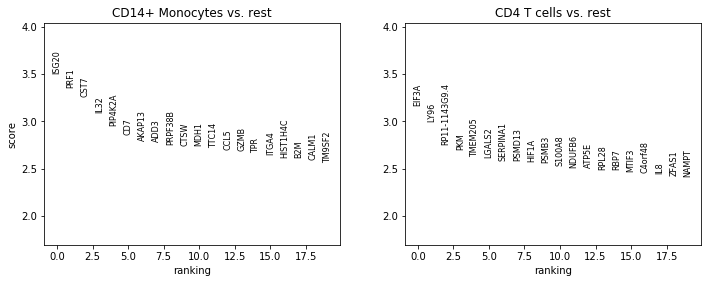

In [38]:
sc.pl.rank_genes_groups(adata_sample)

In [43]:
sc.tl.pca(adata_sample)

In [45]:
sc.pp.neighbors(adata_sample)

In [47]:
sc.tl.umap(adata_sample)

In [ ]:
adata_sample.

In [52]:
adata_sample.obs.head(2)

,batch,batch_cov,ct_cov,disease_cov,ind_cov,pop_cov,well,female,ct_ind,ct_sex,n_counts
index,,,,,,,,,,,
TTCTTAGTCTCAAGTG-2-1-0-0-0-0-0-0-0-0,0,lupus8.2,CD4 T cells,sle,1514_1514,WHITE,YE_8-2-1,1,CD4 T cells - 1514_1514,CD4 T cells - 1,2199.0
TTGAACGAGAGAGCTC-2-1-0-0-0-0-0-0-0-0,0,lupus8.2,CD4 T cells,sle,1514_1514,WHITE,YE_8-2-1,1,CD4 T cells - 1514_1514,CD4 T cells - 1,2073.0


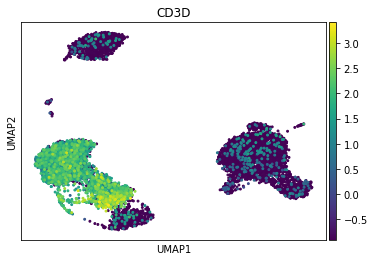

In [59]:
sc.pl.umap(adata_sample, color='CD3D')

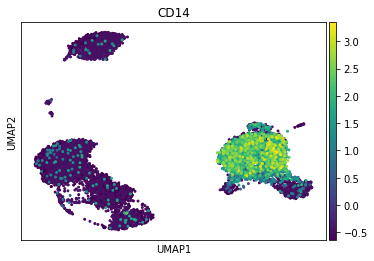

In [60]:
sc.pl.umap(adata_sample, color='CD14')

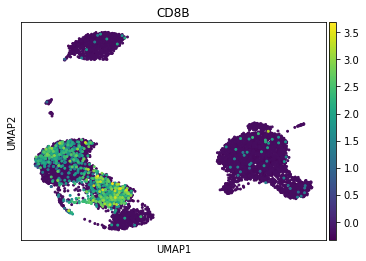

In [73]:
sc.pl.umap(adata_sample, color='CD8B')

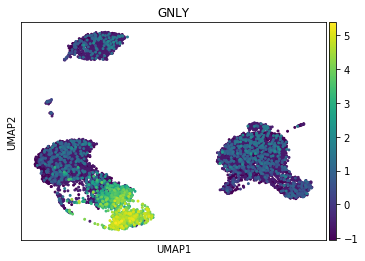

In [74]:
sc.pl.umap(adata_sample, color='GNLY')

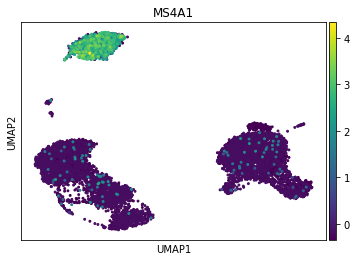

In [78]:
sc.pl.umap(adata_sample, color='MS4A1')

### Fit model

In [230]:
imp.reload(simplesc)
estimator = simplesc.SingleCellEstimator(adata, p=0.1, group_label='ct_cov')

In [231]:
adata.obs.head(5)

,batch,batch_cov,ct_cov,disease_cov,ind_cov,pop_cov,well,female,ct_ind,ct_sex
index,,,,,,,,,,
CCTTCCCTCTGGAGCC-3-1-0-0-0-0-0-0-0-0,0,lupus8.2,NK cells,sle,1414_1414,WHITE,YE_8-2-1,0,NK cells - 1414_1414,NK cells - 0
CCTTCGAAGAGCTGGT-3-1-0-0-0-0-0-0-0-0,0,lupus8.2,CD14+ Monocytes,sle,1414_1414,WHITE,YE_8-2-1,0,CD14+ Monocytes - 1414_1414,CD14+ Monocytes - 0
CCTTCGAAGCCCAGCT-3-1-0-0-0-0-0-0-0-0,0,lupus8.2,CD14+ Monocytes,sle,1414_1414,WHITE,YE_8-2-1,0,CD14+ Monocytes - 1414_1414,CD14+ Monocytes - 0
CCTTCGAAGCGCTTAT-3-1-0-0-0-0-0-0-0-0,0,lupus8.2,CD8 T cells,sle,1414_1414,WHITE,YE_8-2-1,0,CD8 T cells - 1414_1414,CD8 T cells - 0
CCTTCGAAGGGAGTAA-3-1-0-0-0-0-0-0-0-0,0,lupus8.2,Dendritic cells,sle,1414_1414,WHITE,YE_8-2-1,0,Dendritic cells - 1414_1414,Dendritic cells - 0


In [232]:
ct_list = [
    'CD4 T cells',
    'CD14+ Monocytes',
#     'B cells',
#     'NK cells',
#     'Megakaryocytes'
]

In [233]:
for ct in ct_list:
    
    estimator.compute_observed_statistics(group=ct)
    estimator.compute_params(group=ct)
    
#     for ind in [ind_list[1]]:
#         print(ct + ' - ' + ind)
#         estimator.compute_observed_statistics(group=(ct + ' - ' + ind))
#         estimator.compute_params(group=(ct + ' - ' + ind))

In [234]:
lrs = estimator.differential_expression('CD4 T cells', 'CD14+ Monocytes', method='ll')

In [243]:
bayes = estimator.differential_expression('CD4 T cells', 'CD14+ Monocytes', method='bayes')

In [244]:
adata.var.index.values[np.argsort(bayes)[::-1]]\
    [estimator.estimated_mean['CD4 T cells'] > estimator.estimated_mean['CD14+ Monocytes']]\
    [:40]

array(['ILF2', 'C1QBP', 'SNRPG', 'RNF126', 'HSPA8', 'C17orf89', 'FKBP2',
       'C19orf10', 'HNRNPF', 'GNB1', 'RPL22L1', 'HSPE1', 'MRPL51', 'RAC2',
       'H2AFZ', 'EIF3A', 'PHB', 'ATP5A1', 'HNRNPA2B1', 'HSP90AA1',
       'CORO1A', 'IL1B', 'CHCHD2', 'STAT3', 'EAPP', 'SIVA1', 'SLC38A1',
       'ATP5G1', 'XRCC5', 'AKAP9', 'WAC', 'TAP1', 'LSM2', 'WDR74',
       'SEPT1', 'EID1', 'SYNE2', 'PPHLN1', 'SP100', 'CCL4'], dtype=object)

In [251]:
adata.obs.head(2)

,batch,batch_cov,ct_cov,disease_cov,ind_cov,pop_cov,well,female,ct_ind,ct_sex
index,,,,,,,,,,
CCTTCCCTCTGGAGCC-3-1-0-0-0-0-0-0-0-0,0,lupus8.2,NK cells,sle,1414_1414,WHITE,YE_8-2-1,0,NK cells - 1414_1414,NK cells - 0
CCTTCGAAGAGCTGGT-3-1-0-0-0-0-0-0-0-0,0,lupus8.2,CD14+ Monocytes,sle,1414_1414,WHITE,YE_8-2-1,0,CD14+ Monocytes - 1414_1414,CD14+ Monocytes - 0


In [259]:
adata_sample = adata[(adata.obs.ct_cov == 'CD4 T cells').values | (adata.obs.ct_cov == 'CD14+ Monocytes').values]

In [ ]:
sc.pp.regress_out(adata, 'batch')

In [ ]:
sc.tl.rank_genes_groups(adata, 'ct_cov')

In [ ]:
sc.pl.rank_genes_groups(adata)

### Find pseudo-autosomal region

In [39]:
pas_genes = """AKAP17A
ASMT
ASMTL
CD99
CRLF2
CSF2RA
DHRSX
GTPBP6
IL3RA
P2RY8
PLCXD1
PPP2R3B
SHOX
SLC25A6
XG
ZBED1
IL9R
SPRY3
VAMP7
CXYorf1""".split()

### Cell type specific X-inactivation

The phenomena that we're looking for should lead to differential variance among cell types only among women, but not men.

1. QQ plot of p-values
2. 

In [40]:
pas_indices = (adata.var.index.isin(pas_genes))

In [41]:
x_chr_indices = (adata.var['chromosome'] == 'chrX') & ~(pas_indices)

In [209]:
de_bayes_m1 = estimator.differential_expression_bayes('CD4 T cells - 1414_1414', 'CD14+ Monocytes - 1414_1414')
de_bayes_m2 = estimator.differential_expression_bayes('CD4 T cells - 1558_1558', 'CD14+ Monocytes - 1558_1558')

de_bayes_f1 = estimator.differential_expression_bayes('CD4 T cells - 1420_1420', 'CD14+ Monocytes - 1420_1420')
de_bayes_f2 = estimator.differential_expression_bayes('CD4 T cells - 1250_1250', 'CD14+ Monocytes - 1250_1250')

In [392]:
de_bayes_m1[adata.var.index == 'DDX3X']

array([-0.10676869])

In [393]:
de_bayes_f1[adata.var.index == 'DDX3X']

array([-0.07272513])

In [408]:
estimator.differential_expression_bayes('CD4 T cells - 1558_1558', 'CD4 T cells - 1420_1420')[adata.var.index == 'DDX3X']

array([-0.12843634])

In [401]:
adata.var.query('chromosome == "chrX"').head(10)

,gene_ids-0-0-0-0-0-0-0-0-0,gene_ids-1-0-0-0-0-0-0-0-0,gene_ids-1-0-0-0-0-0-0-0,gene_ids-1-0-0-0-0-0-0,gene_ids-1-0-0-0-0-0,gene_ids-1-0-0-0-0,gene_ids-1-0-0-0,gene_ids-1-0-0,gene_ids-1-0,gene_ids-1,n_cells,chromosome
index,,,,,,,,,,,,
GTPBP6,ENSG00000178605,ENSG00000178605,ENSG00000178605,ENSG00000178605,ENSG00000178605,ENSG00000178605,ENSG00000178605,ENSG00000178605,ENSG00000178605,ENSG00000178605,11417,chrX
CSF2RA,ENSG00000198223,ENSG00000198223,ENSG00000198223,ENSG00000198223,ENSG00000198223,ENSG00000198223,ENSG00000198223,ENSG00000198223,ENSG00000198223,ENSG00000198223,12123,chrX
SLC25A6,ENSG00000169100,ENSG00000169100,ENSG00000169100,ENSG00000169100,ENSG00000169100,ENSG00000169100,ENSG00000169100,ENSG00000169100,ENSG00000169100,ENSG00000169100,201659,chrX
P2RY8,ENSG00000182162,ENSG00000182162,ENSG00000182162,ENSG00000182162,ENSG00000182162,ENSG00000182162,ENSG00000182162,ENSG00000182162,ENSG00000182162,ENSG00000182162,16472,chrX
AKAP17A,ENSG00000197976,ENSG00000197976,ENSG00000197976,ENSG00000197976,ENSG00000197976,ENSG00000197976,ENSG00000197976,ENSG00000197976,ENSG00000197976,ENSG00000197976,21015,chrX
CD99,ENSG00000002586,ENSG00000002586,ENSG00000002586,ENSG00000002586,ENSG00000002586,ENSG00000002586,ENSG00000002586,ENSG00000002586,ENSG00000002586,ENSG00000002586,100539,chrX
PRKX,ENSG00000183943,ENSG00000183943,ENSG00000183943,ENSG00000183943,ENSG00000183943,ENSG00000183943,ENSG00000183943,ENSG00000183943,ENSG00000183943,ENSG00000183943,25331,chrX
MSL3,ENSG00000005302,ENSG00000005302,ENSG00000005302,ENSG00000005302,ENSG00000005302,ENSG00000005302,ENSG00000005302,ENSG00000005302,ENSG00000005302,ENSG00000005302,35700,chrX
TMSB4X,ENSG00000205542,ENSG00000205542,ENSG00000205542,ENSG00000205542,ENSG00000205542,ENSG00000205542,ENSG00000205542,ENSG00000205542,ENSG00000205542,ENSG00000205542,273911,chrX


In [406]:
gene = 'MSL3'
estimator.differential_expression_bayes('CD4 T cells - 1414_1414', 'CD4 T cells - 1420_1420')[adata.var.index == gene]

array([0.3280036])

In [157]:
_, dv_bayes_m1 = estimator.differential_variance_bayes('CD4 T cells - 1414_1414', 'CD14+ Monocytes - 1414_1414')
_, dv_bayes_m2 = estimator.differential_variance_bayes('CD4 T cells - 1558_1558', 'CD14+ Monocytes - 1558_1558')

_, dv_bayes_f1 = estimator.differential_variance_bayes('CD4 T cells - 1420_1420', 'CD14+ Monocytes - 1420_1420')
_, dv_bayes_f2 = estimator.differential_variance_bayes('CD4 T cells - 1250_1250', 'CD14+ Monocytes - 1250_1250')

In [377]:
de_cutoff = 0.25
dv_cutoff = 0.1

In [378]:
indices = \
    (((np.absolute(de_bayes_m1) < de_cutoff) & (np.absolute(dv_bayes_m1) < dv_cutoff)) | \
    ((np.absolute(de_bayes_m2) < de_cutoff) & (np.absolute(dv_bayes_m2) < dv_cutoff))) & \
    (((np.absolute(de_bayes_f1) < de_cutoff) & (np.absolute(dv_bayes_f1) > dv_cutoff)) | \
    ((np.absolute(de_bayes_f2) < de_cutoff) & (np.absolute(dv_bayes_f2) > dv_cutoff)))

In [379]:
only_females = adata.var.index.values[indices]

In [383]:
stats.binom_test(
    adata.var[adata.var.index.isin(only_females)].chromosome.value_counts()['chrX'], 
    only_females.shape[0],
    0.030127)

0.25108170851687395

In [321]:
adata.var[adata.var.index.isin(only_females)].chromosome.value_counts()['chrX']

3

In [167]:
adata.var.chromosome.value_counts() / len(adata.var)

chr1     0.100145
chr2     0.070434
chr19    0.068772
chr11    0.061500
chr17    0.060046
chr3     0.056306
chr12    0.055059
chr6     0.053189
chr5     0.048411
chr7     0.043840
chr16    0.042385
chr10    0.035737
chr14    0.035113
chr4     0.034074
chr9     0.032620
chr8     0.031997
chrX     0.030127
chr15    0.027633
chr20    0.025348
chr22    0.024725
nan      0.021193
chr13    0.017868
chr18    0.011843
chr21    0.011427
chrY     0.000208
Name: chromosome, dtype: float64

In [66]:
(dv_bayes_f < -1).sum()

2

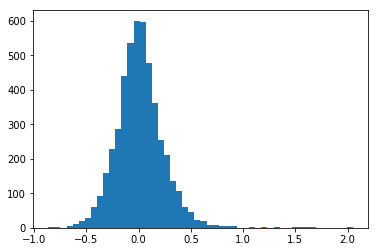

In [63]:
plt.hist(dv_bayes_m, bins=50);

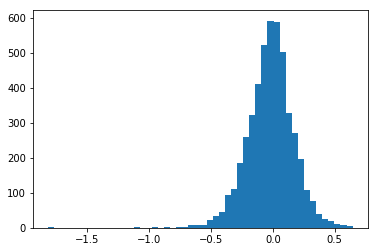

In [62]:
plt.hist(dv_bayes_f, bins=50);

In [36]:
len(diff_var[1])

4813

In [43]:
bf_pvals = np.minimum(diff_var[1] * 4813, 1)

In [48]:
diff_var[1][:10]

array([1.79994942e-40, 9.59572516e-02, 1.18966266e-01, 4.48042293e-80,
       3.31824453e-24, 2.61695176e-02, 3.52343860e-60, 7.79898700e-01,
       4.99858878e-07, 5.93522589e-01])

/anaconda3/envs/scvi/lib/python3.6/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in less_equal
  if __name__ == '__main__':


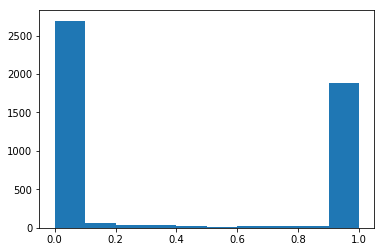

In [52]:
plt.hist(bf_pvals[bf_pvals <= 1]);

/anaconda3/envs/scvi/lib/python3.6/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in less
  if __name__ == '__main__':


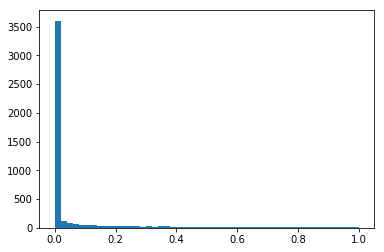

In [33]:
plt.hist(diff_var[1][diff_var[1] < 1], bins=50);

In [28]:
diff_var[1]

array([1.79994942e-40, 9.59572516e-02, 1.18966266e-01, ...,
       7.53029992e-09, 1.70038479e-01, 8.49957711e-57])

In [27]:
diff_var[0]

array([13.92750023, -1.66547167, -1.55976742, ..., -5.79920885,
       -1.37259167, 16.98696933])

In [277]:
x_list = []
auto_list = []

for i in range(100):
    
    greater_var = np.zeros(100)
    greater_var_x = np.zeros(100)
    for trial in range(100):
        for ct in ct_list[:2]:

            ind1, ind2 = np.random.choice(ind_list, 2)

            #plt.figure()
            male_var_x_raw = estimator.estimated_cov['{} - {}'.format(ct, ind1)][x_chr_indices, x_chr_indices].A1
            female_var_x_raw = estimator.estimated_cov['{} - {}'.format(ct, ind2)][x_chr_indices, x_chr_indices].A1

            male_var_x = male_var_x_raw[(male_var_x_raw > 0) & (female_var_x_raw > 0)]
            female_var_x = female_var_x_raw[(male_var_x_raw > 0) & (female_var_x_raw > 0)]

            auto_indices = np.where(~x_chr_indices)[0][:157]
            male_var_auto_raw = estimator.estimated_cov['{} - {}'.format(ct, ind1)][auto_indices, auto_indices].A1
            female_var_auto_raw = estimator.estimated_cov['{} - {}'.format(ct, ind2)][auto_indices, auto_indices].A1

            male_var_auto = male_var_auto_raw[(male_var_auto_raw > 0) & (female_var_auto_raw > 0)]
            female_var_auto = female_var_auto_raw[(male_var_auto_raw > 0) & (female_var_auto_raw > 0)]

        #     _, var_bayes = estimator.differential_variance_bayes('{} - 1'.format(ct), '{} - 0'.format(ct))
        #     _, var_ftest = estimator.differential_variance('{} - 1'.format(ct), '{} - 0'.format(ct))
        #     var_bayes_x = var_bayes[x_chr_indices]
        #     var_bayes_auto = var_bayes[~x_chr_indices]

        #     print(
        #         estimator.estimated_cov['{} - 0'.format(ct)][np.where(adata.var.index == gene)[0][0], np.where(adata.var.index == gene)[0][0]], 
        #         estimator.estimated_cov['{} - 1'.format(ct)][np.where(adata.var.index == gene)[0][0], np.where(adata.var.index == gene)[0][0]])

    #         print(male_var_x.mean(), female_var_x.mean())
    #         print('x',ct, stats.mannwhitneyu(male_var_x, female_var_x))
    #         print('auto', ct, stats.mannwhitneyu(male_var_auto, female_var_auto))

    #         print('Percent of female greater variance (x):', (female_var_x > male_var_x).mean())
    #         print('Percent of female greater variance (auto):', (female_var_auto > male_var_auto).mean())
    #         print('---')

        greater_var[trial] = (female_var_auto.mean() > male_var_auto.mean())
        greater_var_x[trial] = (female_var_x.mean() > male_var_x.mean())
    x_list.append(greater_var_x.mean())
    auto_list.append(greater_var.mean())

In [413]:
levene_p = np.zeros(5000)
ttest_p = np.zeros(5000)
for trial in range(5000):

    dat = stats.norm.rvs(loc=0, scale=1, size=1000)
    dat2 = stats.norm.rvs(loc=0, scale=1.2, size=1000)

    zs = np.absolute(dat)
    zs2 = np.absolute(dat2)

    levene_p[trial] = np.log10(stats.levene(dat, dat2)[1])
    ttest_p[trial] = np.log10(stats.ttest_ind(zs, zs2)[1])

In [ ]:
stats.ttest_ind_from_stats([])

In [321]:
zs = np.absolute(dat-dat.mean())
zs2 = np.absolute(dat2)

In [323]:
stats.ks_2samp(zs, zs2)

Ks_2sampResult(statistic=0.022999999999999993, pvalue=0.951890168048495)

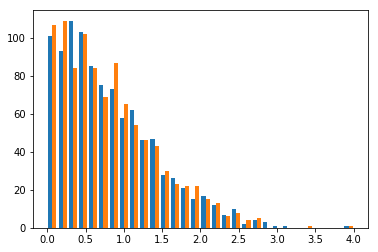

In [322]:
plt.hist([zs, zs2], bins=30);

In [294]:
dat

array([5.11535895, 5.29748073, 5.73198349, 4.02931109, 5.4695484 ,
       4.12094207, 2.77679078, 4.62042263, 3.13393273, 7.15971807,
       6.50690569, 5.74800427, 4.44094727, 5.04895066, 6.31818558,
       5.19584515, 7.22910316, 5.70654494, 4.83236951, 3.62003396,
       2.59624511, 4.90563974, 3.49420014, 6.21349407, 5.45794669,
       4.98962484, 6.41535421, 6.78631337, 5.08749704, 5.25067763,
       4.37993657, 4.68874494, 5.18908643, 6.26833371, 6.61571524,
       4.49294799, 5.63204207, 5.00659471, 6.32569433, 4.53290097,
       5.12971932, 4.91077501, 4.59888238, 3.99158696, 4.49883784,
       5.78073294, 4.96649019, 6.09677435, 5.53860883, 3.9425488 ,
       4.93474909, 4.61963021, 4.25370571, 3.13346951, 3.9680915 ,
       6.11927437, 4.42172241, 4.29798651, 4.0083849 , 5.55541811,
       3.98953795, 6.0890674 , 4.32213063, 4.83312586, 5.49985913,
       6.86287427, 5.43290928, 4.33427933, 4.86416453, 4.20535464,
       5.60561342, 6.02027874, 5.50439794, 4.41649211, 4.01667

In [276]:
print(np.array(x_list).mean(), np.array(auto_list).mean())

0.4522 0.44739999999999996


In [ ]:
greater+var

In [204]:
greater_var.mean()

0.466

In [162]:
1/46

0.021739130434782608

In [53]:
var.shape

(1, 229)

### SCRATCH - for implementing permutation test

In [10]:
adata.obs['ct_ind'].value_counts()

CD14+ Monocytes - 1326_1326      2189
CD14+ Monocytes - 1558_1558      1630
CD14+ Monocytes - 1414_1414      1554
CD14+ Monocytes - 1602_1602      1483
CD4 T cells - 1602_1602          1125
CD4 T cells - 1558_1558          1113
CD4 T cells - 1414_1414           873
CD8 T cells - 1326_1326           812
CD8 T cells - 1602_1602           616
CD4 T cells - 1326_1326           526
FCGR3A+ Monocytes - 1558_1558     489
FCGR3A+ Monocytes - 1414_1414     445
CD8 T cells - 1414_1414           388
NK cells - 1558_1558              378
B cells - 1602_1602               363
NK cells - 1414_1414              359
CD8 T cells - 1558_1558           324
NK cells - 1602_1602              323
FCGR3A+ Monocytes - 1602_1602     314
NK cells - 1326_1326              287
FCGR3A+ Monocytes - 1326_1326     277
B cells - 1414_1414               210
B cells - 1326_1326               194
B cells - 1558_1558               155
Dendritic cells - 1326_1326       147
Dendritic cells - 1414_1414       109
Megakaryocyt

In [11]:
adata.shape

(17117, 1801)

In [12]:
group1 = 'CD14+ Monocytes - 1558_1558'
group2 = 'CD4 T cells - 1558_1558'

In [71]:
data = adata.X.toarray()

In [73]:
num_cells = data.shape[0]
repeat_num = 10

In [69]:
def permute_compute(data, N_1, N_2):
    
    idx = np.random.permutation(N_1 + N_2)
    null_1 = data[idx[:N_1], :]
    null_2 = data[idx[:N_2], :]
    return \
        (null_1.mean(axis=0), 
        np.cov(null_1), 
        null_2.mean(axis=0),
        np.cov(null_2))

In [76]:
N_1 = 10000#(adata.obs['ct_ind'] == group1).values.sum()
N_2 = data.shape[0] - N_1#(adata.obs['ct_ind'] == group2).values.sum()
start = time.time()
wide_data1 = [permute_compute(data, N_1, N_2) for i in range(repeat_num)]
#wide_data1 = sparse.hstack([data[np.random.permutation(num_cells), :].T for i in range(repeat_num)])
print(time.time()-start)

93.00139021873474


In [35]:
start = time.time()
indices = np.concatenate([np.random.permutation(num_cells) for i in range(repeat_num)])#.reshape((-1, num_cells))
rep_data = data[indices, :]
wide_data = sparse.hstack([rep_data[(i*num_cells):((i+1)*num_cells), :] for i in range(repeat_num)])
print(time.time()-start)

6.193097829818726


In [572]:
rep_data.shape

(2743000, 1801)

In [556]:
rep_data.shape

(2743000, 1801)

In [585]:
1.710623025894165*100/60

2.851038376490275

In [560]:
example_data = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])

In [586]:
example_rep_data = example_data[[0, 1, 2, 0, 1, 2], :]

In [593]:
example_rep_data

array([[1, 2, 3],
       [4, 5, 6],
       [7, 8, 9],
       [1, 2, 3],
       [4, 5, 6],
       [7, 8, 9]])

In [592]:
example_rep_data.reshape((3, -1))

array([[1, 2, 3, 4, 5, 6],
       [7, 8, 9, 1, 2, 3],
       [4, 5, 6, 7, 8, 9]])

In [579]:
np.split(rep_data, repeat_num)

ValueError: bad axis1 argument to swapaxes

In [571]:
np.hstack(np.split(rep_data, repeat_num))

ValueError: bad axis1 argument to swapaxes

In [578]:
np.hstack(np.split(example_rep_data, 2))

array([[1, 2, 3, 1, 2, 3],
       [4, 5, 6, 4, 5, 6],
       [7, 8, 9, 7, 8, 9]])

In [561]:
example_data

array([[1, 2, 3],
       [4, 5, 6],
       [7, 8, 9]])

In [ ]:
repeated_data = csr_matrix(np.ones([repeat_number,1])) * data

In [502]:
tensor = np.tile(data, (1, 5))

In [503]:
np.random.shuffle(tensor)

In [505]:
tensor[0, 1].toarray()

array([[1, 2, 3],
       [4, 5, 6],
       [7, 8, 9]], dtype=int64)

In [481]:
np.tile(data, (3, 1, 1))

array([[[1, 2, 3],
        [4, 5, 6],
        [7, 8, 9]],

       [[1, 2, 3],
        [4, 5, 6],
        [7, 8, 9]],

       [[1, 2, 3],
        [4, 5, 6],
        [7, 8, 9]]])

In [468]:
data

<15282x1801 sparse matrix of type '<class 'numpy.float32'>'
	with 5084990 stored elements in Compressed Sparse Row format>

In [464]:
data.shape

(15282, 1801)

In [459]:
adata.X

<15282x1801 sparse matrix of type '<class 'numpy.float32'>'
	with 8357788 stored elements in Compressed Sparse Row format>

In [444]:
adata.obs.

SyntaxError: invalid syntax (<ipython-input-444-821536766b50>, line 1)